In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Callable, Tuple

from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller

### For this exercise, generate 1,000 samples.

In [3]:
np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

ar_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

### Plot your simulated moving average.

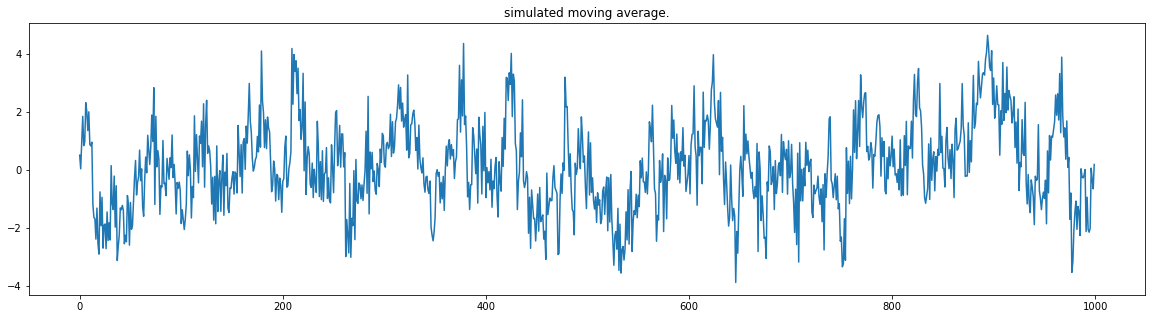

In [4]:
plt.figure(figsize=(20,5))
plt.plot(ar_process);
plt.title('simulated moving average.')
plt.show();

### 3 Run the ADF test and check if the process is stationary. If not, apply differencing.

In [5]:
adf_test = adfuller(ar_process, maxlag=40)
print('Stationary' if adf_test[1] < 0.05 else 'Non Stationary')

Stationary


### 4 Plot the ACF. Is it slowly decaying?

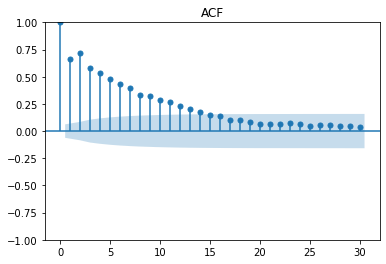

In [8]:
plot_acf(ar_process, title='ACF');

### Plot the PACF. Are there significant coefficients after lag 2?

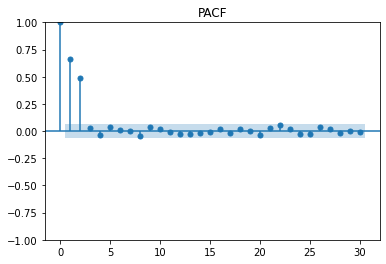

In [12]:
plot_pacf(ar_process, method='ywm', title='PACF');

### 6 Separate your simulated series into train and test sets. Take the first 800 timesteps for the train set and assign the rest to the test set.

In [14]:
n_horizon = 200
train = ar_process[:-n_horizon]
test = ar_process[-n_horizon:]

print(train.shape, test.shape)

(800,) (200,)


### 7 Make forecasts over the test set. Use the historical mean method, last known value method, and an AR(2) model. Use the rolling_forecast function, and use a window length of 2.

In [143]:
def rolling_forecast(arr: np.ndarray, total_len: int, train_len: int, method: str, window: int, 
                     arma_order: Tuple[int, int, int] = None, predict_func:  Callable = None) -> list :
    predicts = []
    for i in range(train_len, total_len, window):
        if method == 'mean':
            mean = np.mean(ar_process[:i])
            predicts.extend(mean for _ in range(window))
        elif method == 'last':
            last_value = ar_process[:i][-1]
            predicts.extend([last_value for _ in range(window)])
        elif method == 'arma':
            predicts.extend(predict_func(ar_process[:i], arma_order, window))
        else:
            raise ValueError('Wrong value of "method" entered.')
    
    return predicts



def prediction_func(arr: np.ndarray, arma_order: Tuple[int, int, int], window: int) -> list :
    arima = ARIMA(arr, order=arma_order)
    arima_fit = arima.fit()
    arima_forecast = arima_fit.get_forecast(steps=window)
    return arima_forecast.predicted_mean

In [150]:
total_len = len(ar_process)
train_len = len(train)
arma_order = (2, 0, 0)
window = 1

predict_mean = rolling_forecast(ar_process, total_len, train_len, 'mean', window)
predict_last = rolling_forecast(ar_process, total_len, train_len, 'last', window)
predict_arma = rolling_forecast(ar_process, total_len, train_len, 'arma', window, arma_order, prediction_func)

### 8 Plot your forecasts.

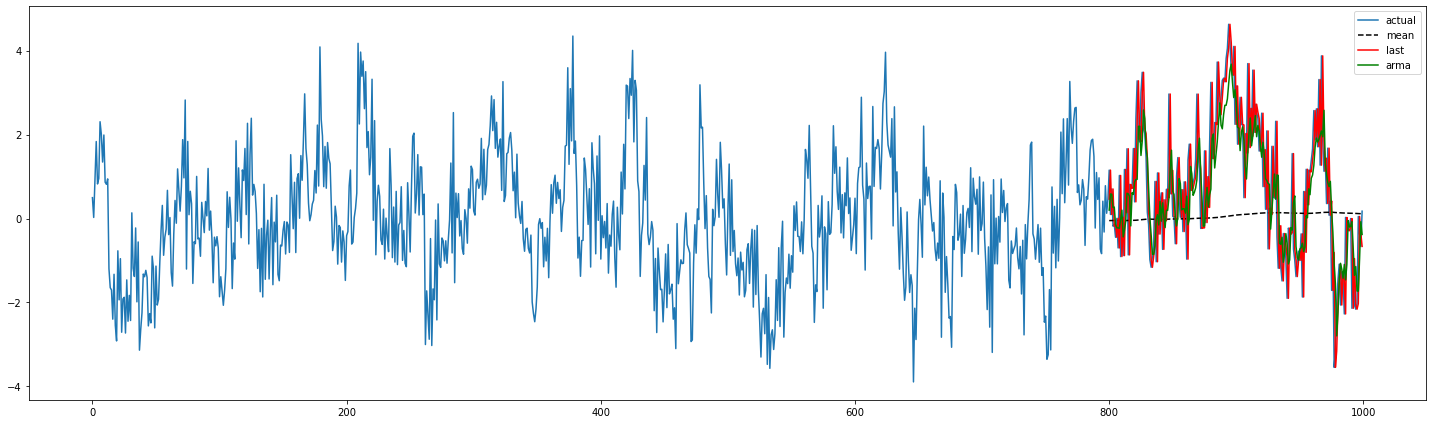

In [151]:
fig, ax = plt.subplots(figsize=(20,6))

blank_train = np.repeat(np.nan, train_len)

ax.plot(ar_process, label='actual')
ax.plot(np.hstack((blank_train, predict_mean)), 'k--', label='mean')
ax.plot(np.hstack((blank_train, predict_last)), 'r-', label='last')
ax.plot(np.hstack((blank_train, predict_arma)), 'g',  label='arma')

ax.legend()

plt.tight_layout()
plt.show()

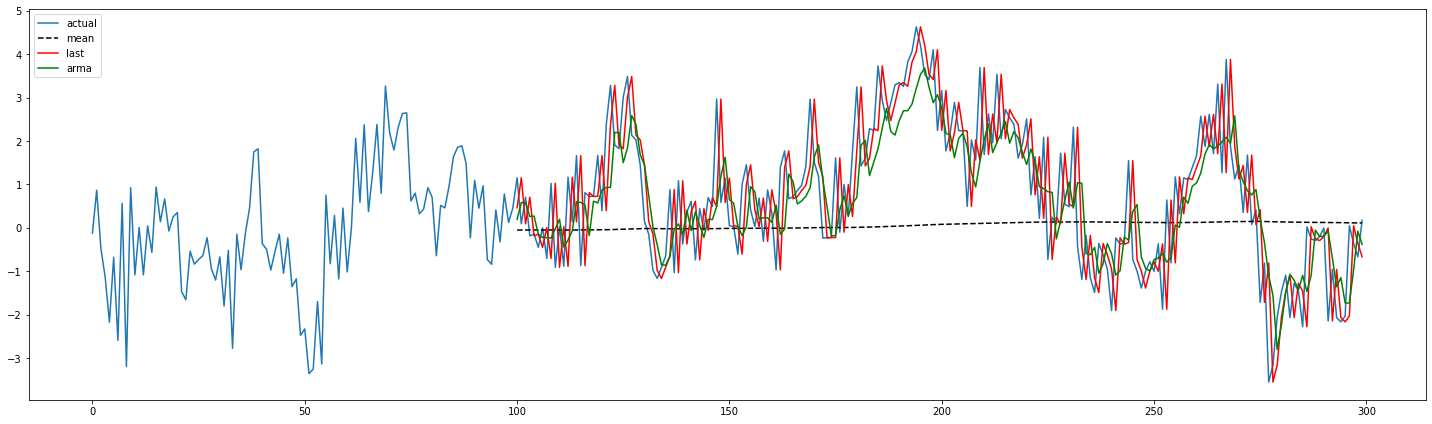

In [152]:
fig, ax = plt.subplots(figsize=(20,6))

blank_train = np.repeat(np.nan, train_len)

ax.plot(ar_process[-300:], label='actual')
ax.plot(np.hstack((blank_train, predict_mean))[-300:], 'k--', label='mean')
ax.plot(np.hstack((blank_train, predict_last))[-300:], 'r-', label='last')
ax.plot(np.hstack((blank_train, predict_arma))[-300:], 'g',  label='arma')

ax.legend(loc=2)

plt.tight_layout()
plt.show()

### 9. Measure the MSE, and identify your champion model.

In [153]:
mse_mean = mean_squared_error(test, predict_mean)
mse_last = mean_squared_error(test, predict_last)
mse_arma = mean_squared_error(test, predict_arma)

print(mse_mean, mse_last, mse_arma)

3.085647290783316 1.3825808304875022 0.9322857152399684


### 10 Plot your MSEs in a bar plot.

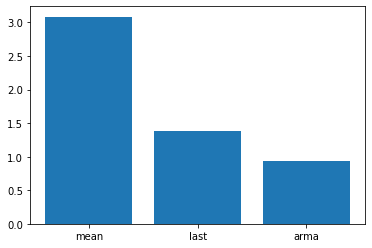

In [154]:
plt.bar(['mean', 'last', 'arma'], [mse_mean, mse_last, mse_arma]);